# Denoising

In this notebook, we demonstrate the denoising capability of `phase2vec` over and above a LASSO baseline. You can choose the type of of noise you'd like, generate the data and compare the ability of `phase2vec` to reproduce clean parameters and velocities. 

In [1]:
import os
import subprocess
from phase2vec.utils import get_command_defaults, ensure_dir, write_yaml, update_yaml
from phase2vec.train import load_model, train_model, run_epoch
from phase2vec.data import load_dataset, SystemFamily
from phase2vec.train._losses import *

/Users/nomo/opt/miniconda3/envs/phase2vec2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate noisy data
First we generate noisy data. Include the systems you'd like in the list `noise_data_names` and then edit `noise_type` and `noise_mag` to adjust the style and strength of noise. 

In [2]:
## Generate data
outdir = '../output/' # Alter to change where all of the phase2vec data will be saved. 
data_dir = os.path.join(outdir, 'data')

# Edit the data included in training and testing here. 
noise_data_names  = ['saddle_node', 'pitchfork', 'transcritical',
                    'selkov', 'homoclinic', 'vanderpol',
                    'simple_oscillator', 'fitzhugh_nagumo', 'lotka_volterra']

# Edit the type of noise here
noise_type = 'trajectory' #'gaussian', 'masking', 'parameter'
noise_mag=2000 # for "trajectory", the bigger the integer, the less noise; for other types of noise, the bigger the float, the bigger the noise.
tt = 1.0
alpha = .01
device='cpu'
num_samples = 100

noise_system_classes = []
for system in [SystemFamily(data_name=name) for name in noise_data_names]:
    noise_system_classes += [system.data_name + ' ' + str(i) for i in range(len(system.param_groups))]

samplers    = ['uniform'] * len(noise_data_names)
props       = [str(1. / len(noise_data_names))] * len(noise_data_names)
noise_data_names   = '-s ' +  ' -s '.join(noise_data_names)
samplers     = '-sp ' +  ' -sp '.join(samplers)
props = '-c ' +  ' -c '.join(props)

In [3]:
## Generate noisy data
subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --data-set-name classical_noise_type_{noise_type}_mag_{noise_mag} --noise-type {noise_type} --noise-mag {noise_mag} --num-samples {num_samples} {noise_data_names} {samplers} {props} --tt {tt} --alpha {alpha} ', shell=True)

Generating saddle_node data.
Generating pitchfork data.
Generating transcritical data.
Generating selkov data.
Generating homoclinic data.
Generating vanderpol data.
Generating simple_oscillator data.
Generating fitzhugh_nagumo data.
Generating lotka_volterra data.


0

In [4]:
## Generate clean data
subprocess.call(f'phase2vec generate-dataset --data-dir {data_dir} --data-set-name classical_no_noise --num-samples {num_samples} {noise_data_names} {samplers} {props}', shell=True)

Generating saddle_node data.
Generating pitchfork data.
Generating transcritical data.
Generating selkov data.
Generating homoclinic data.
Generating vanderpol data.
Generating simple_oscillator data.
Generating fitzhugh_nagumo data.
Generating lotka_volterra data.


0

Next we load each data set. 

In [5]:
import numpy as np

# Load noisy data
noisy_data_path = os.path.join(data_dir, f'classical_noise_type_{noise_type}_mag_{noise_mag}')
X_noisy1, X_noisy2, y_noisy1, y_noisy2, p_noisy1, p_noisy2 = load_dataset(noisy_data_path)
X_noisy = np.concatenate([X_noisy1, X_noisy2])
y_noisy = np.concatenate([y_noisy1, y_noisy2])
p_noisy = np.concatenate([p_noisy1, p_noisy2])

# Load clean data
clean_data_path = os.path.join(data_dir, f'classical_no_noise')
X_clean1, X_clean2, y_clean1, y_clean2, p_clean1, p_clean2 = load_dataset(clean_data_path)
X_clean = np.concatenate([X_clean1, X_clean2])
y_clean = np.concatenate([y_clean1, y_clean2])
p_clean = np.concatenate([p_clean1, p_clean2])

# Load model and evaluate

We now load a pretrained model which we assume was saved under the name `sparse_train_<beta>` where `beta` is the value used during the training period. You can edit the variable `beta` or the model save directory directly if the model was saved elsewhere. These values are set to match the default values in the `train_and_eval` notebook. 

In [6]:
## Set net parameters
from phase2vec.cli._cli import generate_net_config

beta = 1e-3
net_info = get_command_defaults(generate_net_config)
model_type = net_info['net_class']
model_save_dir  = os.path.join(outdir, f'models/sparse_train_{beta}')

# These parameters are not considered architectural parameters for the net, so we delete them before they're passed to the net builder. 
del net_info['net_class']
del net_info['output_file']
del net_info['pretrained_path']
del net_info['ae']

net = load_model(model_type, pretrained_path=os.path.join(model_save_dir, 'model.pt'), device=device, **net_info).to(device)
net.eval()

CNNwFC_exp_emb(
  (enc): CNN(
    (conv_layers): Sequential(
      (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
  )
  (emb): MLP(
    (layers): Sequential(
      (0): Linear(in_features=6272, out_features=100, bias=True)
    )
  )
  (dec): MLP(
    (layers): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=128, out_fea

Here are a few helper functions that make it easier to compare `phase2vec` and `lasso`. 

In [7]:
def forward_p2v(net, data):
    b = data.shape[0]
    n = data.shape[2]
    emb  = net.emb(net.enc(data).reshape(b, -1))
    out  = net.dec(emb)
    pars = out.reshape(-1,net.library.shape[-1], 2)
    recon = torch.einsum('sl,bld->bsd',net.library.to(device),pars).reshape(b, n,n,2).permute(0,3,1,2)
    return pars, recon

def forward_lasso(net, data):
    b = data.shape[0]
    n = data.shape[2]
    # LASSO
    pars = []
    for z in data:
        zx = z[0,:,:].numpy().flatten()
        zy = z[1,:,:].numpy().flatten()
        clf = linear_model.Lasso(alpha=1e-3)
        clf.fit(net.library.numpy(), zx)
        mx = clf.coef_
        clf.fit(net.library.numpy(), zy)
        my = clf.coef_
        pars.append(torch.stack([torch.tensor(mx), torch.tensor(my)]))
    pars = torch.stack(pars).permute(0,2,1)
    recon = torch.einsum('sl,bld->bsd',net.library.to(device),pars).reshape(b,n,n,2).permute(0,3,1,2)  
    return pars, recon

## Evaluate average performance on each system, 

In [8]:

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import linear_model
import pdb

# Places to store intermediate results
loss_dict = {}
sorted_data = []
sorted_data_clean = []
recon_dict = {'p2v':[],'lasso':[]}
fp_normalize = True

# Set loss
euclidean = normalized_euclidean if fp_normalize else euclidean_loss

# Don't forget this part!
net.eval()
for label in tqdm(np.unique(y_noisy)):
    
    # Noisy data for this class
    data_noisy   = torch.tensor([datum for (d, datum) in enumerate(X_noisy) if y_noisy[d] == label])
    pars_noisy   = torch.tensor([par for (p, par) in enumerate(p_noisy) if y_noisy[p] == label])
    labels = torch.ones(len(data_noisy)) * label
    
    sorted_data += list(data_noisy)
    
    # Clean data for this class
    data_clean   = torch.tensor([datum for (d, datum) in enumerate(X_clean) if y_clean[d] == label])
    pars_clean   = torch.tensor([par for (p, par) in enumerate(p_clean) if y_clean[p] == label])
    labels_clean = torch.ones(len(data_clean)) * label
    
    sorted_data_clean += list(data_clean)
    
    # Both the p2v and lasso loss for this class
    class_par_losses = []
    class_recon_losses = []
    # For each fitting method
    for nm, forward in zip(recon_dict.keys(),[forward_p2v, forward_lasso]):
        
        # Fit pars and return recon
        pars_fit, recon = forward(net, data_noisy.float())
    
        # Par loss
        par_loss   = euclidean_loss(pars_fit, pars_clean).detach().cpu().numpy()
        # Recon loss
        recon_loss = euclidean(recon, data_clean).detach().cpu().numpy()
        class_par_losses.append(par_loss)
        class_recon_losses.append(recon_loss) 
        
        recon_dict[nm] += list(recon)    
    loss_dict[noise_system_classes[label]] = class_recon_losses + class_par_losses
df = pd.DataFrame(data=loss_dict)
df.index = [ 'Recon-P2V', 'Recon-LASSO', 'Param-P2V', 'Param-LASSO']

  0%|                                                                         | 0/16 [00:00<?, ?it/s]/var/folders/8y/cpqrd46n7ml80f139vjz9l240000gn/T/ipykernel_46692/1536298262.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  data_noisy   = torch.tensor([datum for (d, datum) in enumerate(X_noisy) if y_noisy[d] == label])
100%|████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.01it/s]


In [9]:
# Show data frame of results
df

,saddle_node 0,saddle_node 1,pitchfork 0,pitchfork 1,transcritical 0,transcritical 1,selkov 0,selkov 1,homoclinic 0,homoclinic 1,vanderpol 0,simple_oscillator 0,simple_oscillator 1,fitzhugh_nagumo 0,fitzhugh_nagumo 1,lotka_volterra 0
Recon-P2V,0.4713102,0.41088384,0.46200162,0.4300786,0.48827067,0.47242418,1.9893122,1.6884359,0.65636116,0.65945137,1.1616677,0.63755625,0.55969954,0.85274094,0.8604048,3.9455216
Recon-LASSO,0.40676904,0.6503662,0.11872295,0.101570904,0.11446439,0.112017654,4.6204257,3.665614,0.3427519,0.32695985,0.33877155,0.16792609,0.10456254,0.41621906,0.5914664,2.0302904
Param-P2V,0.124741346,0.12985228,0.13024312,0.11566537,0.15218014,0.13739581,11.488858,10.601391,2.3821206,2.2281756,8.610621,0.37346435,0.2866727,4.650764,4.650211,0.2671718
Param-LASSO,0.21150078,0.23223086,0.21592955,0.19897544,0.23797065,0.23604459,18.470175,18.289753,5.070867,4.472695,20.849325,0.6413262,0.5510193,8.473112,8.415238,0.7226012


In [10]:
# Show average performance of phase2vec vs lasso
df.mean(axis=1)

Recon-P2V      0.984133
Recon-LASSO    0.881806
Param-P2V      2.895596
Param-LASSO    5.455548
dtype: float64

## Visualize Reconstructions
Finally, we visualize some randomly sampled vector fields and their reconstructions via both `phase2vec` and LASSO. 

/var/folders/8y/cpqrd46n7ml80f139vjz9l240000gn/T/ipykernel_46692/367561877.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


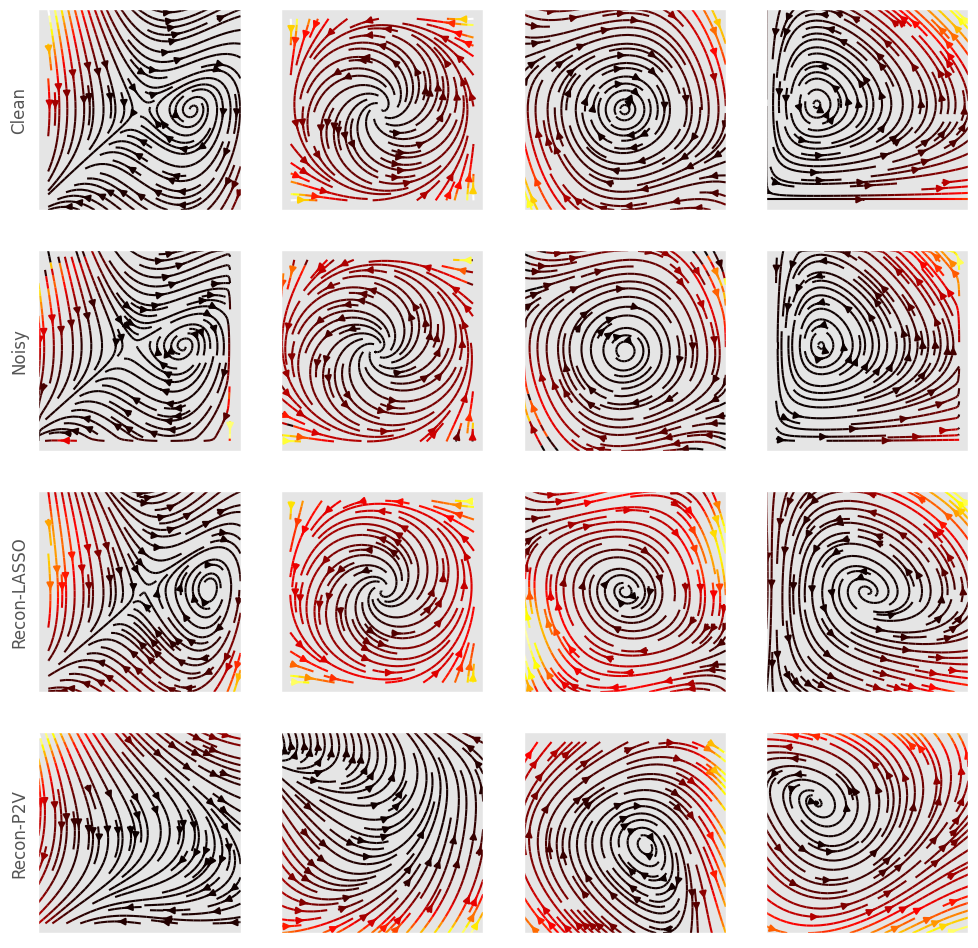

In [11]:
# Get embedding inds
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pdb

num_data = X_noisy.shape[0]
num_lattice = X_noisy.shape[2]

x = np.linspace(-1.0,1.0, num_lattice)
y = np.linspace(-1.0,1.0,num_lattice)

num_vis = 4
vis_inds = np.random.permutation(num_data)[:num_vis]
fig, axes = plt.subplots(4,4,figsize=(12,12))

vis_data = [sorted_data[ind].detach().numpy() for ind in vis_inds]
vis_clean = [sorted_data_clean[ind].detach().numpy() for ind in vis_inds]
vis_recons_lasso = [recon_dict['lasso'][ind].detach().numpy() for ind in vis_inds]
vis_recons_p2v = [recon_dict['p2v'][ind].detach().numpy() for ind in vis_inds]

for a, (col, clean, noisy, recon_lasso, recon_p2v) in enumerate(zip(axes.T, vis_clean, vis_data, vis_recons_lasso, vis_recons_p2v)):
    for row, arr, nm in zip(col, [clean, noisy, recon_lasso, recon_p2v], ['Clean', 'Noisy', 'Recon-LASSO', 'Recon-P2V']):
        arr = arr.transpose(0,2,1)

        row.streamplot(x,y,arr[0],arr[1],color=(arr**2).sum(0), cmap='hot')
        if a == 0:
            row.set_ylabel(nm)
    for ax in col:
        ax.grid(b=None)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()
plt.close()